<a href="https://colab.research.google.com/github/robecm/404TNF-BACK/blob/main/ExoPtolomy_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINDING EXOPLANETS WITH AI - NASA SPACE APPS CHALLENGE 2025

In [ ]:
! pip install lightkurve pandas numpy seaborn matplotlib tsfel scikit-learn snowflake-connector-python lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import lightkurve as lk
from google.colab import drive
import matplotlib.pyplot as plt
import tsfel
import joblib
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### KOI DATA

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NASA Space Apps Challenge /koi_data.csv'

try:
    df_koi = pd.read_csv(file_path, skiprows=144)
    print("CSV file read successfully:")
    display(df_koi.head())
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")



CSV file read successfully:


,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


[3670 3666]
Entrenando el modelo LightGBM en un escenario realista...
[LightGBM] [Info] Number of positive: 3666, number of negative: 3670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7336, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499727 -> initscore=-0.001091
[LightGBM] [Info] Start training from score -0.001091
Entrenamiento completado.

--- Métricas de Evaluación del Modelo Realista ---
                precision    recall  f1-score   support

     CANDIDATE       0.82      0.87      0.84       917
FALSE POSITIVE       0.86      0.81      0.83       917

      accuracy                           0.84      1834
     macro avg       0.84      0.84      0.84      1834
  weighted avg       0.84      0.84      0.84      1834

Exactitud General (Acc

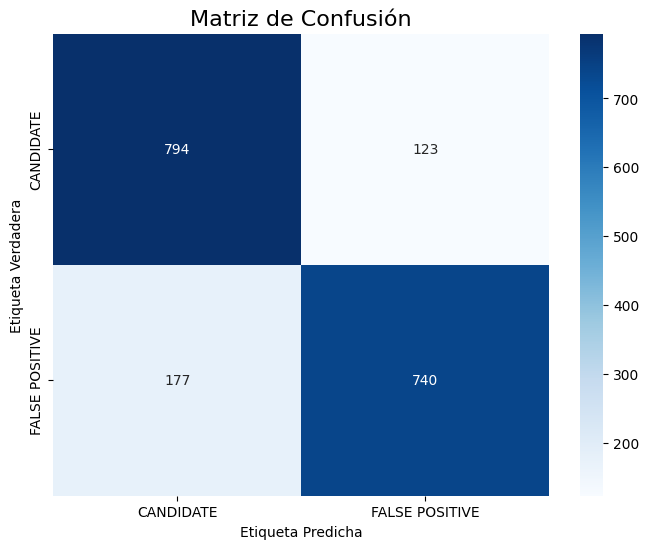

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset desde tu ruta
file_path = '/content/drive/MyDrive/Colab Notebooks/NASA Space Apps Challenge /koi_train.csv'
df = pd.read_csv(file_path, comment='#')

# 1. Preprocesamiento de Datos
# ¡CAMBIO CRÍTICO! Hemos eliminado 'koi_score' Y TODAS las 'koi_fpflag_'.
# Ahora el modelo solo puede usar mediciones físicas.
potential_features = [
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad'
]
target_col = 'koi_pdisposition'
df_model = df[potential_features + [target_col]].copy()
# df_model[target_col] = df_model[target_col].apply(lambda x: 'PLANET' if x in ['CONFIRMED', 'CANDIDATE'] else 'FALSE POSITIVE')
df_model.dropna(inplace=True)

# 2. Preparación para el Modelo
le = LabelEncoder()
y = le.fit_transform(df_model[target_col])
X = df_model[potential_features]

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

unique_values, counts = np.unique(y_train, return_counts=True)
print(counts)

# 3. Entrenamiento del Modelo LightGBM (usando la versión regularizada)
print("Entrenando el modelo LightGBM en un escenario realista...")
lgbm_model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=120,
    learning_rate=0.03,
    num_leaves=25,
    reg_alpha=0.1,
    reg_lambda=0.05,
    #boosting_type="dart"
)

lgbm_model.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],
               eval_metric='logloss',
               callbacks=[lgb.early_stopping(10, verbose=False)]) # 'verbose=False' para un output más limpio

print("Entrenamiento completado.")

# 4. Realizar Predicciones y Evaluar
y_pred = lgbm_model.predict(X_test)

print("\n--- Métricas de Evaluación del Modelo Realista ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud General (Accuracy): {accuracy:.4f}")
print("--------------------------------------")



# 5. Evaluación del Modelo
print("\n--- Métricas de Evaluación del Modelo ---")
# Usamos classification_report para obtener un resumen completo
# 'le.classes_' nos ayuda a ver las etiquetas como 'PLANET' en lugar de 0 y 1
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Imprimimos la exactitud general
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud General (Accuracy): {accuracy:.4f}")
print("--------------------------------------")


# 6. Visualización de la Matriz de Confusión
print("\nGenerando Matriz de Confusión...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión', fontsize=16)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig('confusion_matrix.png')
print("Matriz de Confusión guardada como 'confusion_matrix.png'")

# --- Guardado del Modelo y del Codificador ---
# Guardamos el modelo entrenado para poder usarlo después
joblib.dump(lgbm_model, 'exoplanet_model.pkl')
# También guardamos el LabelEncoder para poder decodificar las predicciones
joblib.dump(le, 'label_encoder.pkl')

print("\n¡Éxito! El modelo ha sido guardado como 'exoplanet_model.pkl'")
print("El codificador de etiquetas ha sido guardado como 'label_encoder.pkl'")

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

print("Iniciando el proceso de predicción en nuevos datos...")

# --- Carga del Modelo y del Codificador ---
# Cargamos los archivos que guardamos en el script de entrenamiento
try:
    model = joblib.load('exoplanet_model.pkl')
    le = joblib.load('label_encoder.pkl')
    print("Modelo y codificador cargados exitosamente.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos 'exoplanet_model.pkl' o 'label_encoder.pkl'.")
    print("Por favor, ejecuta primero el script 'train_model.py'.")
    exit()

# --- Carga de Nuevos Datos para Probar ---
# Asegúrate de que este path apunte a tu archivo de prueba con los 20 registros
test_file_path = '/content/drive/MyDrive/Colab Notebooks/NASA Space Apps Challenge /koi_test.csv'
df_test = pd.read_csv(test_file_path)

# --- Preparación de los Nuevos Datos ---
# Es crucial usar exactamente las mismas columnas que en el entrenamiento
features = [
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad'
]
target_col = 'koi_pdisposition'



# Seleccionamos las características y eliminamos filas con nulos si las hubiera
X_new = df_test[features].dropna()
# Guardamos las etiquetas verdaderas para poder comparar
y_true_new = df_test.loc[X_new.index, target_col] # .loc para evitar errores de alineación

# --- Realizar Predicciones ---
print("Realizando predicciones...")
predictions_encoded = model.predict(X_new)
# Usamos el codificador cargado para convertir los números (0, 1) a texto ('PLANET', etc.)
predictions = le.inverse_transform(predictions_encoded)

# --- Mostrar Resultados ---
# Creamos un DataFrame para comparar los resultados de forma clara
results_df = pd.DataFrame({
    'Predicción del Modelo': predictions,
    'Resultado Verdadero': y_true_new
})

print("\n--- Resultados de la Predicción en los Datos de Prueba ---")
print(results_df)
print("-" * 50)

# Mostramos un reporte completo de métricas
print("\n--- Reporte de Clasificación en Datos de Prueba ---")
print(classification_report(y_true_new, predictions))

Iniciando el proceso de predicción en nuevos datos...
Modelo y codificador cargados exitosamente.
Realizando predicciones...

--- Resultados de la Predicción en los Datos de Prueba ---
   Predicción del Modelo Resultado Verdadero
0         FALSE POSITIVE      FALSE POSITIVE
1         FALSE POSITIVE      FALSE POSITIVE
2         FALSE POSITIVE      FALSE POSITIVE
3         FALSE POSITIVE           CANDIDATE
4         FALSE POSITIVE      FALSE POSITIVE
5         FALSE POSITIVE      FALSE POSITIVE
6         FALSE POSITIVE      FALSE POSITIVE
7         FALSE POSITIVE      FALSE POSITIVE
8              CANDIDATE      FALSE POSITIVE
9         FALSE POSITIVE      FALSE POSITIVE
10             CANDIDATE      FALSE POSITIVE
11        FALSE POSITIVE      FALSE POSITIVE
12             CANDIDATE      FALSE POSITIVE
13             CANDIDATE           CANDIDATE
14        FALSE POSITIVE      FALSE POSITIVE
15        FALSE POSITIVE      FALSE POSITIVE
16        FALSE POSITIVE      FALSE POSITIVE
17   

Curva de luz


In [ ]:
# Unique kepler IDs to extract light curves
l_kepid = list(df_koi['kepid'].unique())
len(l_kepid)

In [ ]:
# Extract light curves
# List of dataframes
cfg = tsfel.get_features_by_domain()
l_df = []

# Iterate over kepids
for ii in [11446443]:# l_kepid[:int(len(l_kepid)/2)]:
  # search for light curve of kepid ii
  print(f"Extracting data from {str(ii)}")
  search_result = lk.search_lightcurve(target=str(ii), mission='Kepler', quarter=1)
  print(search_result)

  # if results not found skip
  if len(search_result) == 0:
    continue

  # download info
  lc_collection = search_result[0].download()

  # if info not found skip
  if lc_collection is None:
    continue

  # stitch - concatenate chronologically;
  lc = lc_collection.remove_nans().normalize()

  df_lc = lc.to_pandas().reset_index()

  df_lc["kepid"] = ii

  l_df.append(df_lc[["kepid", "time", "flux"]].copy())

# df concatenation
df_fin = pd.concat(l_df, ignore_index=True)
df_fin.head(200)


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_lc['flux'])
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve')
plt.grid(True)
plt.show()